In [15]:
import os
os.environ["DISABLE_TQDM"] = "1"   # <-- disables ALL tqdm progress bars

import warnings
warnings.filterwarnings("ignore", message="IProgress not found")
warnings.filterwarnings("ignore")

from pathlib import Path
import json

from dotenv import load_dotenv
from transformers import AutoModelForCausalLM, AutoTokenizer, logging as hf_logging
from safetensors.torch import load_file
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

hf_logging.set_verbosity_error()
hf_logging.disable_progress_bar()


In [16]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
if hf_token is None:
    raise RuntimeError("HF_TOKEN not found in .env")


In [17]:
def model_exists(path: Path) -> bool:
    return (path / "config.json").exists()


In [18]:
import io
import contextlib

load_dotenv()
hf_token = os.getenv("HF_TOKEN")
if hf_token is None:
    raise RuntimeError("HF_TOKEN not found.")

def model_exists(path: Path) -> bool:
    return (path / "config.json").exists()

def load_model_quietly(model_dir, model_id, hf_token):
    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer), contextlib.redirect_stderr(buffer):
        if model_exists(model_dir):
            source = "local cache"
            tok = AutoTokenizer.from_pretrained(model_id, token=hf_token)
            mdl = AutoModelForCausalLM.from_pretrained(
                model_dir,
                local_files_only=True,
                device_map="auto",
            )
        else:
            source = "Hugging Face Hub"
            tok = AutoTokenizer.from_pretrained(model_id, token=hf_token)
            mdl = AutoModelForCausalLM.from_pretrained(
                model_id,
                token=hf_token,
                device_map="auto",
            )
            model_dir.mkdir(parents=True, exist_ok=True)
            tok.save_pretrained(model_dir)
            mdl.save_pretrained(model_dir)

    print(f"Model source: {source}")
    print("Model loaded.")
    return tok, mdl

tokenizer, model = load_model_quietly(MODEL_DIR, MODEL_ID, hf_token)


Model source: local cache
Model loaded.


In [19]:
def format_size(size_bytes: int) -> str:
    if size_bytes < 1024:
        return f"{size_bytes} B"
    elif size_bytes < 1024**2:
        return f"{size_bytes/1024:.2f} KB"
    elif size_bytes < 1024**3:
        return f"{size_bytes/(1024**2):.2f} MB"
    else:
        return f"{size_bytes/(1024**3):.2f} GB"


In [20]:
FILE_DESCRIPTIONS = {
    "tokenizer.json": "Core tokenizer vocabulary and merge rules.",
    "tokenizer_config.json": "Tokenizer configuration.",
    "special_tokens_map.json": "Special token definitions.",
    "config.json": "Model architecture definition.",
    "generation_config.json": "Default generation settings.",
    "model.safetensors.index.json": "Index mapping tensors to shards.",
}

def get_file_description(name: str) -> str:
    if name in FILE_DESCRIPTIONS:
        return FILE_DESCRIPTIONS[name]
    if name.startswith("model-") and name.endswith(".safetensors"):
        return "Model weight shard."
    return "Misc file."


In [21]:
def get_shard_param_counts(model_dir: Path):
    index_path = model_dir / "model.safetensors.index.json"
    if not index_path.exists():
        print("Index not found.")
        return {}

    with open(index_path) as f:
        index_data = json.load(f)

    weight_map = index_data.get("weight_map", {})
    shard_groups = {}

    for tensor, shard in weight_map.items():
        shard_groups.setdefault(shard, []).append(tensor)

    shard_param_counts = {}

    print("\nParameter counts per shard:")
    for shard, names in shard_groups.items():
        tensors = load_file(model_dir / shard)
        total = sum(tensors[n].numel() for n in names)
        shard_param_counts[shard] = total
        print(f"{shard}: {total:,} (~{total/1e9:.3f} B)")

    return shard_param_counts

shard_param_counts = get_shard_param_counts(MODEL_DIR)



Parameter counts per shard:
model-00001-of-00003.safetensors: 1,249,689,600 (~1.250 B)
model-00002-of-00003.safetensors: 1,233,199,104 (~1.233 B)
model-00003-of-00003.safetensors: 729,861,120 (~0.730 B)


In [22]:
def print_model_dir_summary(model_dir: Path, shard_param_counts: dict):
    print("\nModel summary:")
    header = f"{'Filename':35s} {'Size':>12s}  {'Parameters':>24s}  Description"
    print(header)
    print("-" * len(header))

    for path in sorted(model_dir.glob("*")):
        if not path.is_file() or path.name == "chat_template.jinja":
            continue

        size = format_size(path.stat().st_size)
        params = shard_param_counts.get(path.name)
        p_str = "-" if params is None else f"{params:,} (~{params/1e9:.3f} B)"
        desc = get_file_description(path.name)

        print(f"{path.name:35s} {size:>12s}  {p_str:>24s}  {desc}")

print_model_dir_summary(MODEL_DIR, shard_param_counts)



Model summary:
Filename                                    Size                Parameters  Description
---------------------------------------------------------------------------------------
config.json                                866 B                         -  Model architecture definition.
generation_config.json                     184 B                         -  Default generation settings.
model-00001-of-00003.safetensors         4.66 GB  1,249,689,600 (~1.250 B)  Model weight shard.
model-00002-of-00003.safetensors         4.59 GB  1,233,199,104 (~1.233 B)  Model weight shard.
model-00003-of-00003.safetensors         2.72 GB    729,861,120 (~0.730 B)  Model weight shard.
model.safetensors.index.json            20.46 KB                         -  Index mapping tensors to shards.
special_tokens_map.json                    296 B                         -  Special token definitions.
tokenizer.json                          16.41 MB                         -  Core tokenizer vocab

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,} (~{total_params/1e9:.3f} B)")



Total parameters: 3,212,749,824 (~3.213 B)


In [24]:
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 120,
})


In [25]:
def collect_file_stats(model_dir: Path, shard_param_counts: dict):
    names = []
    sizes_gb = []
    pretty_sizes = []
    params_b = []

    for path in sorted(model_dir.glob("*")):
        if not path.is_file() or path.name == "chat_template.jinja":
            continue

        size_bytes = path.stat().st_size
        names.append(path.name)
        sizes_gb.append(size_bytes / (1024**3))
        pretty_sizes.append(format_size(size_bytes))

        p = shard_param_counts.get(path.name)
        params_b.append(p/1e9 if p is not None else None)

    return names, sizes_gb, pretty_sizes, params_b

names, sizes_gb, pretty_sizes, params_b = collect_file_stats(MODEL_DIR, shard_param_counts)


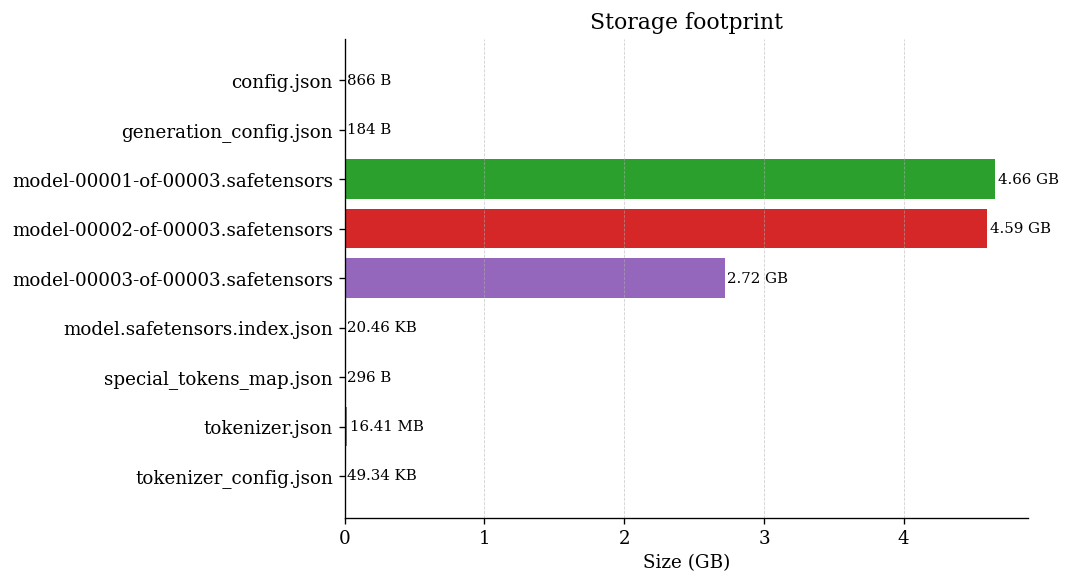

In [26]:
def plot_model_component_sizes(names, sizes_gb, pretty_sizes):
    fig, ax = plt.subplots(figsize=(9, 5))
    y = range(len(names))
    cmap = plt.cm.get_cmap("tab10")
    colors = [cmap(i % cmap.N) for i in y]

    ax.barh(y, sizes_gb, color=colors)
    ax.set_yticks(y)
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.set_xlabel("Size (GB)")
    ax.set_title("Storage footprint")

    for i, (width, label) in enumerate(zip(sizes_gb, pretty_sizes)):
        ax.text(width + 0.02, i, label, va="center", fontsize=9)

    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_model_component_sizes(names, sizes_gb, pretty_sizes)


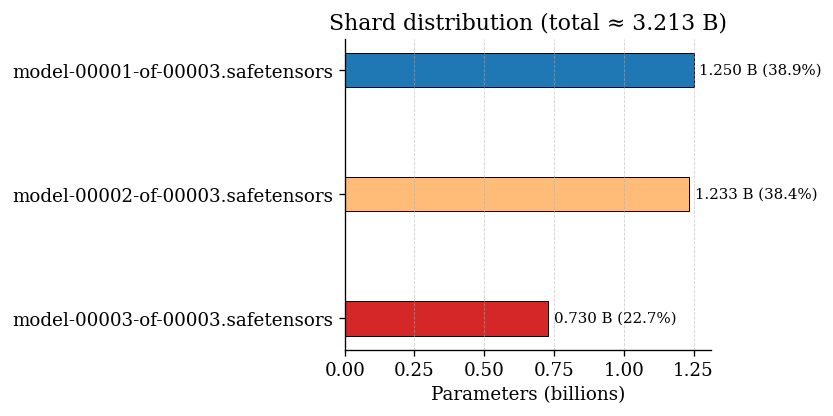


Shard breakdown:
model-00001-of-00003.safetensors: 1,249,689,600 ≈ 1.250 B (38.9%)
model-00002-of-00003.safetensors: 1,233,199,104 ≈ 1.233 B (38.4%)
model-00003-of-00003.safetensors: 729,861,120 ≈ 0.730 B (22.7%)


In [27]:
def plot_shard_parameters(shard_param_counts):
    if not shard_param_counts:
        print("No shard stats.")
        return

    names = list(shard_param_counts.keys())
    vals = [shard_param_counts[n] for n in names]
    vals_b = [v/1e9 for v in vals]
    total = sum(vals)
    total_b = total / 1e9

    fig, ax = plt.subplots(figsize=(7, 3.6))
    y = range(len(names))
    cmap = plt.cm.get_cmap("tab20")
    colors = [cmap((i*3) % cmap.N) for i in y]

    ax.barh(y, vals_b, color=colors, height=0.28, edgecolor="black", linewidth=0.6)
    ax.set_yticks(y)
    ax.set_yticklabels(names)
    ax.invert_yaxis()

    ax.set_xlabel("Parameters (billions)")
    ax.set_title(f"Shard distribution (total ≈ {total_b:.3f} B)")

    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

    for i, (v_b, v_raw) in enumerate(zip(vals_b, vals)):
        pct = v_raw / total * 100
        ax.text(v_b + 0.02, i, f"{v_b:.3f} B ({pct:.1f}%)", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\nShard breakdown:")
    for n, v_raw, v_b in zip(names, vals, vals_b):
        pct = v_raw / total * 100
        print(f"{n}: {v_raw:,} ≈ {v_b:.3f} B ({pct:.1f}%)")

plot_shard_parameters(shard_param_counts)
